## Biodiversity in national parks 

### Dataset description
- `species_info.csv`: contains data about different species and their conservation status. Fields:
  - `scientific_name`, latin name that uniquely identifies the species 
  - `common_names`, other names that the species is known for 
  - `category`, species classification
  - `conservation_status`, mostly filled with `nan`s possibly due to most of the species being of least concern (not endangered)  
- `observations.csv`: holds recorded sightings of different species at several national parks for the past 7 days. Fields: 
  - `scientific_name`, same as in `species_info.csv`
  - `park_name`, name of the north american park where the species was identified 
  - `observations`, species count 

### Dataset preparation

In [6]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np   

df_species = pd.read_csv("species_info.csv")
df_obs = pd.read_csv("observations.csv")

# drop duplicates of species information
df_species.drop_duplicates(subset=['scientific_name'], inplace=True)

# merge information
df = pd.merge(df_obs, df_species, on='scientific_name', how='left')

In [7]:
# All nan are due to conservation_status
print(df.isna().sum())

scientific_name            0
park_name                  0
observations               0
category                   0
common_names               0
conservation_status    22536
dtype: int64


Making subsets of the dataset

In [48]:
## df1 -> counts of species in each category grouped by conservation status 
df1 = df.groupby(["conservation_status", "category"])['scientific_name'].count().reset_index()
df1.rename(columns={"scientific_name":"species_count"}, inplace=True)
# pivot the table for easier plotting 
df1 = df1.pivot(index='category', columns='conservation_status', values='species_count')
# fill NaNs
df1.fillna(0, inplace=True)
# remove plants
df1.drop(index=['Nonvascular Plant', 'Vascular Plant'], inplace=True)
df1

conservation_status,Endangered,In Recovery,Species of Concern,Threatened
category,,,,
Amphibian,4.0,0.0,16.0,8.0
Bird,16.0,12.0,288.0,0.0
Fish,12.0,0.0,16.0,12.0
Mammal,32.0,0.0,112.0,8.0
Reptile,0.0,0.0,20.0,0.0


In [49]:
## df2 -> sum of observations in each category grouped by national park 
df2 = df.groupby(["park_name", "category"])['observations'].sum().reset_index()
plants = (df2.category=='Nonvascular Plant') | (df2.category=='Vascular Plant') 
df2 = df2[~plants]
df2.head()

,park_name,category,observations
0,Bryce National Park,Amphibian,7380
1,Bryce National Park,Bird,51647
2,Bryce National Park,Fish,12423
3,Bryce National Park,Mammal,20550
5,Bryce National Park,Reptile,7950


In [50]:
## df3 -> sum of observations for each conservation status grouped by national park 
df3 = df.groupby(["park_name", "conservation_status"])["observations"].sum().reset_index()
# remove species of concern because there are too many and the others end up not being visible in the plot 
species_of_concern = df3.conservation_status == 'Species of Concern'
df3 = df3[~species_of_concern]
df3.head()

,park_name,conservation_status,observations
0,Bryce National Park,Endangered,489
1,Bryce National Park,In Recovery,258
3,Bryce National Park,Threatened,427
4,Great Smoky Mountains National Park,Endangered,334
5,Great Smoky Mountains National Park,In Recovery,189


In [53]:
## df4 -> sum of observations grouped by conservatino status and category 
df4 = df.groupby(["category", "conservation_status"])['observations'].sum().reset_index()
# drop plants 
plants = (df4.category=='Vascular Plant') | (df4.category == 'Nonvascular Plant')
df4 = df4[~(plants)]
df4 = df4.pivot(index='category', values='observations', columns='conservation_status')
df4.head()

conservation_status,Endangered,In Recovery,Species of Concern,Threatened
category,,,,
Amphibian,144.0,NaN,2044.0,564.0
Bird,574.0,1392.0,36642.0,NaN
Fish,455.0,NaN,2109.0,832.0
Mammal,1463.0,NaN,14408.0,578.0
Reptile,NaN,NaN,2536.0,NaN


### Plots

#### Stacked bar chart - species count according to category and conservation status

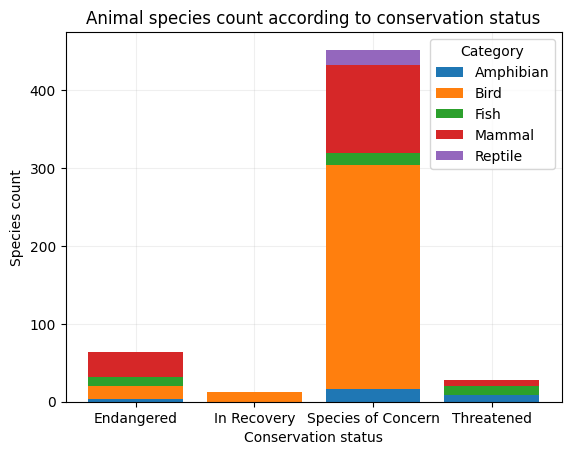

In [55]:
fig, ax = plt.subplots()
categories = df1.index
x = df1.columns
for idx, category in enumerate(categories):
  y = df1.loc[category, :]
  if idx == 0:
    ax.bar(x, y, label=category, zorder=2)
    bottom = np.array(y) 
  else: 
    ax.bar(x, y, bottom=bottom, label=category, zorder=2)
    # update bottom for next iterations
    bottom += np.array(y)

ax.set_xlabel("Conservation status")
ax.set_ylabel("Species count")
ax.grid(alpha=0.2, zorder=-1)
ax.set_title("Animal species count according to conservation status")
ax.legend(title="Category")
plt.show()
fig.savefig('species_count_per_status.png')

#### Animal species observed according to national park and category

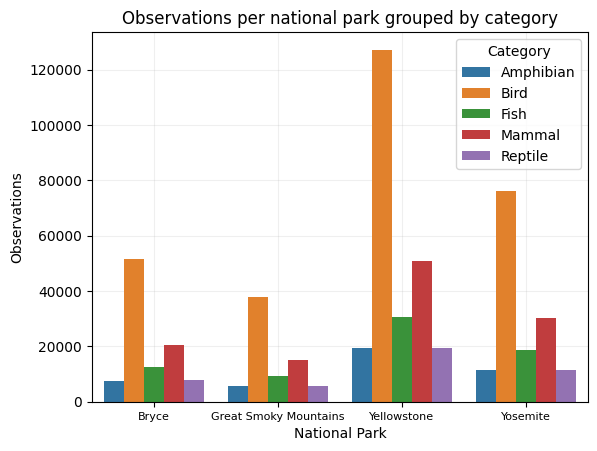

In [56]:
df2.rename(columns={"category":"Category"}, inplace=True)
ax = sns.barplot(data=df2, x='park_name', y='observations', hue='Category', zorder=2)
split_names = df2.park_name.str.split(" (National Park)")
x_labels = split_names.str.get(0).unique()
ax.set_xticklabels(x_labels, fontsize=8)
ax.grid(alpha=0.2)
ax.set_xlabel("National Park")
ax.set_ylabel("Observations")
ax.set_title("Observations per national park grouped by category")
plt.show()
fig.savefig('observations_per_park_category.png')

Animal species observed according to national park and conservation status (except species of concern)

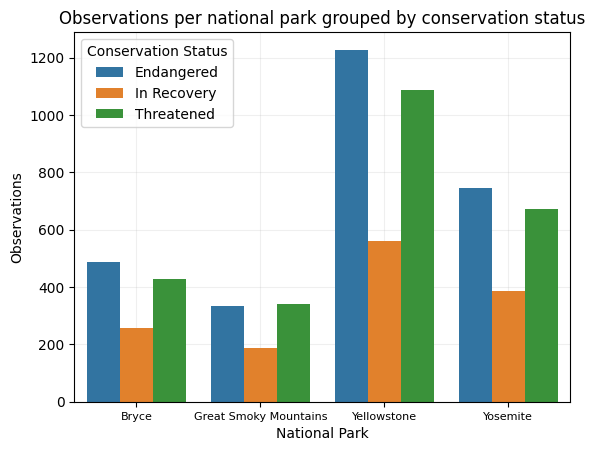

In [57]:
df3.rename(columns={"conservation_status": "Conservation Status"}, inplace=True)
ax = sns.barplot(data=df3, x='park_name', y='observations', hue='Conservation Status',zorder=2)
split_names = df3.park_name.str.split(" (National Park)")
x_labels = split_names.str.get(0).unique()
ax.set_xticklabels(x_labels, fontsize=8)
ax.set_xlabel("National Park")
ax.set_ylabel("Observations")
ax.grid(alpha=0.2, zorder=-1)
ax.set_title("Observations per national park grouped by conservation status")
plt.show()
fig.savefig('observations_per_park_status.png')

Animal observations grouped by conservation status and category 

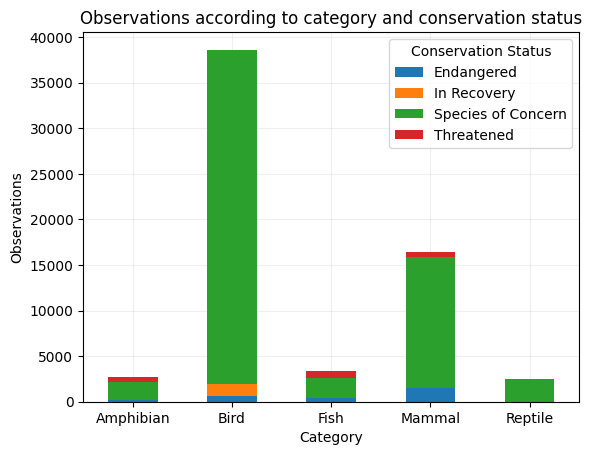

In [58]:
df4.columns.name='Conservation Status'
ax = df4.plot(kind='bar', stacked=True, zorder=2)
ax.set_xlabel("Category")
ax.set_ylabel("Observations")
ax.grid(alpha=0.2, zorder=-1)
ax.set_xticklabels(df4.index, rotation=0)
ax.set_title("Observations according to category and conservation status")
plt.show()
fig.savefig('observations_per_category_status.png')

### Summary of findings  
- Out of all animal categories, birds show the largest number of species that currently have the conservation status of "species of concern". They are also the only category that contains species with a conservation status of "in recovery". 
- Mammals have the largest amount of species in the endangered status, followed by birds. 
- The Great Smoky Mountains National Park has the lowest number of animal observations when compared with the other parks. On the other hand, the Yellowstone National Park has the largest number of animal observations with over 120,000 sightings of birds alone. 
- In all parks, birds are the animal category that have the largest number of observations. 
- For animal species that are not of least concern and also not species of concern, the Yellowstone National Park has the largest amount of sightings of "endangered" species (over 1,200), and also of "threatened" and "in recovery" species. This is expected given the abundant number of observations from Yellowstone relative to other parks. 
- Summing up the observations across all parks and removing the observations of species of "least concern", birds are the animal category with the largest amount of observations (totaling over 40,000), while reptiles have the lowest. This is expected given that in all of the analyzed parks, birds are the most commonly observed animal category. 